# 1. Setup

## 1.1 Import Packages

In [130]:
#Import Python packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# for splitting of the dataset
from sklearn.model_selection import train_test_split

# for encoding/transforming the data
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.preprocessing import MinMaxScaler

#ML-Models: Regression
import xgboost as xgb
from xgboost import XGBRegressor

#Building clustering model
from sklearn.cluster import KMeans 

# for getting metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

# model selection
from sklearn.model_selection import GridSearchCV

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
# Define a simple scoring function
from cachetools import cached

## 1.2 Connect to Snowflake

In [2]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [3]:
session.sql("ALTER WAREHOUSE TASTY_BI_WH SET WAREHOUSE_SIZE = MEDIUM").collect()

[Row(status='Statement executed successfully.')]

## 1.3 Gathering Data as Snowpark DataFrame

In [4]:
# Orders_V
# contains orders, trucks, shift information
tasty_bytes_orders_v = session.table("frostbyte_tasty_bytes.analytics.orders_v")
# Customer Loyalty
# contains information on signed up members
tasty_bytes_customer_loyalty = session.table("frostbyte_tasty_bytes.raw_customer.customer_loyalty")

locations= session.table("frostbyte_tasty_bytes.raw_pos.location")

menu= session.table("frostbyte_tasty_bytes.raw_pos.menu")
#Sentiment_Survey_ds
# contains NPS score
SENTIMENT_DATA = session.table("ngee_ann_polytechnic_frostbyte_data_share.raw_survey.sentiment_survey_ds")
# Truck information data
TRUCK_DATA = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_pos.truck")
# Comparison Data
NPS_COMPARE = session.table("NPS_COMPARE")

# 2. Data Exploration 

## 2.0 Model Value Towards Tasty Byte KPI

### 2.0.1 Define function - Remove Duplicate Columns from Joins

In [5]:
#Function to remove and rename columns after inner join
def remove_dup_join_col(df):
    # capitalise all columns
    for col in df.columns:
        df = df.withColumnRenamed(col, col.upper())
    
    # get list of renamable columns for left and right join
    left_dup_col = [col_name for col_name in df.columns if col_name.startswith('L_')]
    right_dup_col = [col_name for col_name in df.columns if col_name.startswith('R_')]
    old_columns = df.columns
    
    # rename the list with the most number of renamable columns
    # drop the list of columns with less number of renamable columns
    if len(left_dup_col)>len(right_dup_col):
        columns_rename=left_dup_col
        df= df.drop(*right_dup_col)
    else:
        columns_rename=right_dup_col
        df= df.drop(*left_dup_col)
    
    for old_column in old_columns:
        if old_column in columns_rename:
            # get string to remove
            string_to_replace = columns_rename[0][:7]
            # replace starting string
            new_column = old_column.replace(string_to_replace, "")
            df = df.withColumnRenamed(old_column, new_column)
    
    return df

We get the churn cut off date by country. This is done by subtracting 14 days from the latest order date, with 14 days being the assumed churn period. These values are compared with the time stamp so that we can identify which customers were active within the time frame and how many left. 

<b>We decided to work on United States as it has the most number of customers, a high number of customers and quite a high Churn Rate.

# 3. Data Engineering

## 3.1 Generate new Columns

In [6]:
#Merge to get loyal customers orders
loyal_customer_orders=tasty_bytes_orders_v.join(
    right=tasty_bytes_customer_loyalty,
    on="CUSTOMER_ID",
    how="inner"
)

In [7]:
#Remove duplicate columns
loyal_customer_orders = remove_dup_join_col(loyal_customer_orders)

#Remove duplicate order ids
remove_dup = loyal_customer_orders.dropDuplicates(['ORDER_ID'])

### 3.1.1 Get Latest Order Date

In [8]:
# called `orders` with columns `customer_id` and `order_ts`
window_spec = Window.partitionBy('customer_id').orderBy(F.col('order_ts').desc())

orders_with_rank = remove_dup.withColumn('rank', F.rank().over(window_spec))

# Get max order of each customer
max_order_ts = orders_with_rank.filter(F.col('rank') == 1).select('customer_id', 'order_ts')


In [9]:
# Rename columns
max_order_ts = max_order_ts.withColumnRenamed('ORDER_TS','Max_Order_TS')

In [10]:
# Merge with second max order dataframe
max_Order=remove_dup.join(right=max_order_ts,on='CUSTOMER_ID',how='inner')

#Filter out last purchase
filtered_df = max_Order.filter(F.col('ORDER_TS') < F.col('Max_Order_TS'))


We got the latest order date to filter out the last purchase and its also used to get the days to next order. Since our target variable is closely related to the days to next order, we filter out the last purchase to not leak future information such that we are able to prevent target leakage.

### 3.1.2 RFM (Recency, Freqency, Monetary)

In [12]:
# Get last purchase date as a variable
lastdate=filtered_df.select(F.max('ORDER_TS')).first()[0]

# Recency
recency = filtered_df.groupBy('CUSTOMER_ID').agg(F.max('ORDER_TS').alias('ORDER_TS'))
recency = recency.withColumn('RECENCY', F.datediff(col1=F.col('ORDER_TS'), col2=F.lit(lastdate),part='day'))

# Frequency
frequency = filtered_df.groupBy('CUSTOMER_ID').agg(F.countDistinct('ORDER_ID').alias('frequency'))

# Monetary
monetary = filtered_df.groupBy('CUSTOMER_ID').agg(F.sum('ORDER_TOTAL').alias('monetary'))

# Merge into RFM table
RFM_table = recency.join(frequency, on='CUSTOMER_ID', how='inner')
RFM_table = RFM_table.join(monetary, on='CUSTOMER_ID', how='inner')


This code is used to get RFM, Recency, Frequency, and Monetary for each customer. The purpose of doing this is to generate new features and show the customer's behavioural data.

### 3.1.3 Average Time Difference, Max and Min Days without Purchase

In [13]:
# Define a window partitioned by customer and menu item, ordered by date
window_spec = Window.partitionBy("CUSTOMER_ID").orderBy("DATE")

# Add a column with the date of the prior order for each customer 
orders_df = filtered_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.lag("DATE").over(window_spec))

# Calculate the number of days between the prior order and the current order for each customer and menu item
orders_df = orders_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.datediff(col1="DAYS_SINCE_PRIOR_ORDER", col2="DATE",part='day'))
orders_df = orders_df.na.drop(subset=["DAYS_SINCE_PRIOR_ORDER"])

# Calculate the average purchase time difference for each customer
avg_time_diff=orders_df.group_by('CUSTOMER_ID').agg(F.round(F.avg('DAYS_SINCE_PRIOR_ORDER'),0).alias('Avg_Days_Between_Purchase'))

# Max Days without Purchase
max_days=orders_df.group_by('CUSTOMER_ID').agg(F.max('DAYS_SINCE_PRIOR_ORDER').alias('Max_Days_Without_Purchase'))

# Min Days without Purchase
min_days=orders_df.group_by('CUSTOMER_ID').agg(F.min('DAYS_SINCE_PRIOR_ORDER').alias('Min_Days_Without_Purchase'))

This code is used to get the average purchase time difference for each customers. This is done by calculating the most number of days a customer has gone without purchasing and the least number of days the customer has gone without purchasing. These features are also to show the behavioural information of each customer.

### 3.1.4 Creating Age and getting Customer's Gender, Marital Status and Country

In [14]:
# Get Customer demographic
cust_demo=tasty_bytes_customer_loyalty.select('CUSTOMER_ID','BIRTHDAY_DATE','GENDER','MARITAL_STATUS','COUNTRY','CITY','SIGN_UP_DATE','CHILDREN_COUNT')

# get AGE variable
cust_demo = cust_demo.withColumn("AGE", F.datediff('year', F.col("BIRTHDAY_DATE"),F.lit(lastdate)))

# Show
cust_demo.show()

---------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"BIRTHDAY_DATE"  |"GENDER"     |"MARITAL_STATUS"  |"COUNTRY"  |"CITY"          |"SIGN_UP_DATE"  |"CHILDREN_COUNT"  |"AGE"  |
---------------------------------------------------------------------------------------------------------------------------------------------
|1              |1953-12-01       |Female       |Single            |Germany    |Hamburg         |2019-02-19      |0                 |69     |
|2              |1973-09-21       |Male         |Single            |Brazil     |Rio de Janeiro  |2019-10-07      |0                 |49     |
|3              |2000-09-04       |Female       |Married           |Poland     |Krakow          |2020-09-11      |2                 |22     |
|4              |1950-03-05       |Female       |Single            |Poland     |Krakow          |2021-09-09      |1                 |72     |
|5    

We added a new column called "AGE" which contains the age of the customer at the time of the latest transaction. We also retrieved new columns like the customer's gender, marital status and country.

### Attempted Improvements to the model

#### Improved the Model

In [15]:
# Number of locations visited
num_of_locations_visited=filtered_df.group_by('CUSTOMER_ID').agg(F.countDistinct('LOCATION_ID').alias('NUM_OF_LOCATIONS_VISITED'))

In [37]:
# Assuming filtered_df contains the DataFrame with customer_id and order_ts columns
window_spec = Window.partitionBy('customer_id').orderBy(F.col('order_ts').asc())

# Add rank to each order for each customer
orders_with_rank = filtered_df.withColumn('rank', F.rank().over(window_spec))

# Get the first order of each customer
first_order_ts = orders_with_rank.filter(F.col('rank') == 1).select('customer_id', 'order_ts')

In [38]:
first_order_ts=first_order_ts.withColumn('last_date', F.lit(lastdate))

In [39]:
# Calculate the difference in days between the first and last order
tenure = first_order_ts.withColumn('Tenure_days', F.datediff(col1='order_ts', col2='last_date',part='day'))
tenure=tenure.withColumn('Tenure_months', F.datediff(col1='order_ts', col2='last_date',part='month'))

tenure=tenure.drop(['ORDER_TS','last_date'])

tenure.show()

---------------------------------------------------
|"CUSTOMER_ID"  |"TENURE_DAYS"  |"TENURE_MONTHS"  |
---------------------------------------------------
|159782         |1025           |33               |
|120967         |844            |27               |
|116112         |1289           |42               |
|80263          |1216           |39               |
|137604         |1272           |41               |
|179067         |985            |32               |
|180287         |978            |32               |
|17474          |1021           |33               |
|200016         |1177           |38               |
|86937          |1274           |41               |
---------------------------------------------------



In [40]:
# Add Length of relationship

window_spec = Window.partitionBy('customer_id').orderBy(F.col('order_ts').asc())

orders_with_rank = filtered_df.withColumn('rank', F.rank().over(window_spec))

# Get max order of each customer
first_order_ts = orders_with_rank.filter(F.col('rank') == 1).select('customer_id', 'order_ts')

# Join the first_orders and last_orders DataFrames on customer_id
joined_orders = first_order_ts.join(max_order_ts, 'customer_id')

# Calculate the difference in days between the first and last order
diff_in_days = joined_orders.withColumn('Length_of_Relationship', F.datediff(col1='order_ts', col2='max_order_ts',part='day'))

diff_in_days=diff_in_days.drop(['ORDER_TS','MAX_ORDER_TS'])

diff_in_days.show()

--------------------------------------------
|"CUSTOMER_ID"  |"LENGTH_OF_RELATIONSHIP"  |
--------------------------------------------
|75233          |1257                      |
|111803         |807                       |
|86257          |1041                      |
|128730         |1111                      |
|193437         |1252                      |
|5719           |980                       |
|3502           |918                       |
|19851          |1207                      |
|220305         |1178                      |
|8776           |1024                      |
--------------------------------------------



### 3.1.5 Join Generated Variables

In [94]:
# Merge to get final dataframe
final_df = RFM_table.join(max_order_ts, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(avg_time_diff, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(max_days, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(min_days, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(cust_demo,on='CUSTOMER_ID',how='inner')
final_df = final_df.join(diff_in_days,on='CUSTOMER_ID',how='inner')
final_df = final_df.join(tenure,on='CUSTOMER_ID',how='inner')
final_df = final_df.join(num_of_locations_visited,on='CUSTOMER_ID',how='inner')



We joined all the different tables to get all the columns in the same table by inner joining all the different tables on the CUSTOMER_ID column. The joined table contains all the different features we will be using to predict the target.

#### Attempted Improvement: Created Relative Purchase Frequency and Monetary

In [95]:
final_df=final_df.with_column('RELATIVE_PURCHASE_FREQUENCY',(F.col('FREQUENCY')/F.col('Length_of_Relationship')).cast('float'))
final_df=final_df.with_column('RELATIVE_PURCHASE_MONETARY',(F.col('MONETARY')/F.col('Length_of_Relationship')).cast('float'))

### 3.1.6 Days to Next Order

In [96]:
# Convert timestamp to date such that Days to next orders is more accurate
final_df=final_df.with_column('ORDER_TS',F.to_date(F.col('ORDER_TS')))
final_df=final_df.with_column('MAX_ORDER_TS',F.to_date(F.col('MAX_ORDER_TS')))

In [97]:
# Add Days To Next Order
final_df = final_df.withColumn('Days_To_Next_Order', F.datediff(col1=final_df['ORDER_TS'], col2=final_df['MAX_ORDER_TS'],part='day'))

In [98]:
# Get median of Days to next order
final_df.select(F.median('DAYS_TO_NEXT_ORDER')).show()

------------------------------------
|"MEDIAN(""DAYS_TO_NEXT_ORDER"")"  |
------------------------------------
|9.000                             |
------------------------------------



We use the median number of days since the prior order for the global dataset to create a target variable that distinguishes customers who purchase below or above this median. Customers who purchase below the median will be labeled as 'Not churn', while those who purchase above the median will be labeled as 'Churn'. This approach will help us identify customers who may require retention strategies and predict their level of engagement with our business.

The median days to next order is 9 for customers from all countries, this will be used to check if our train dataset's target variable is representative of the global dataset.

### 3.1.7 Filter to selected Country

In [99]:
# Filter to United States
final_df=final_df.filter(F.col('COUNTRY')=='United States')

We filtered the data to only have records for the United States. This is because we are only interested in the United States as shown above due to its high churn rate and high number of customers

In [100]:
# Sort CustomerID
final_df=final_df.sort('CUSTOMER_ID')

In [101]:
# Convert to pandas
final_df=final_df.to_pandas()

We converted the table to pandas because we want to carry out data manipulation.

## 3.2 Outlier Handling

### 3.2.1 Identify Numericals

In [102]:
num_cols=final_df.select_dtypes(exclude=['object','datetime64[ns]']).columns

### 3.2.2 Visualise Outliers

In [103]:
# Function to explore the distributuion of variables
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    fig=plt.figure(figsize=(12, 4))
    fig.suptitle(variable)
    
    # histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30,kde=True)
    plt.title('Histogram')

    # boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    
    plt.show()

In [104]:
# function to create before and after histogram
def before_after_histogram(df_before,df_after, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df_before[variable], bins=30)
    plt.title('Before')

    # histogram
    plt.subplot(1, 2, 2)
    sns.histplot(df_after[variable], bins=30)
    plt.title('After')

    plt.suptitle(variable)

    plt.show()

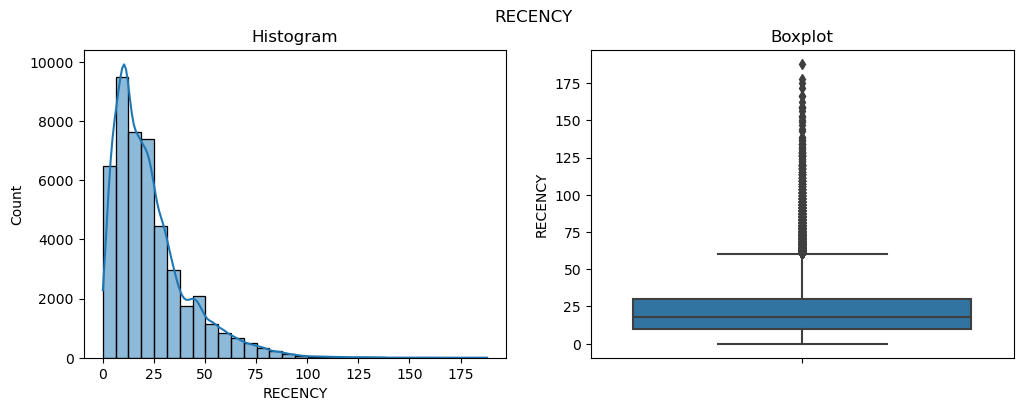

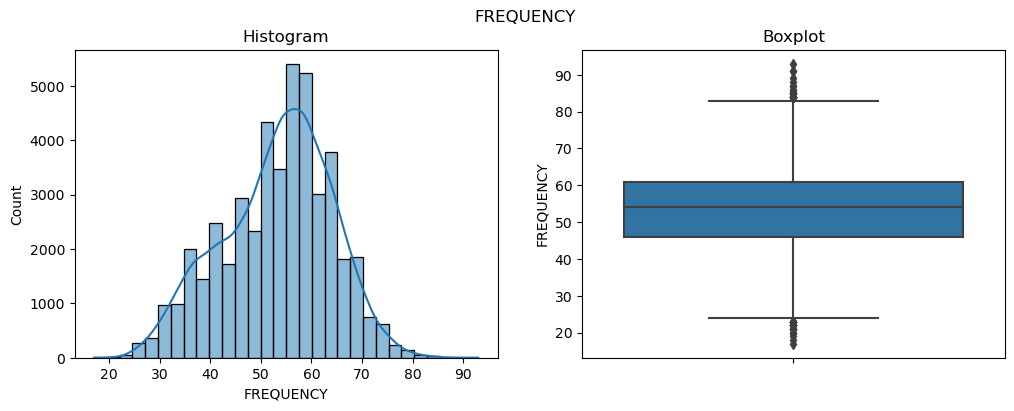

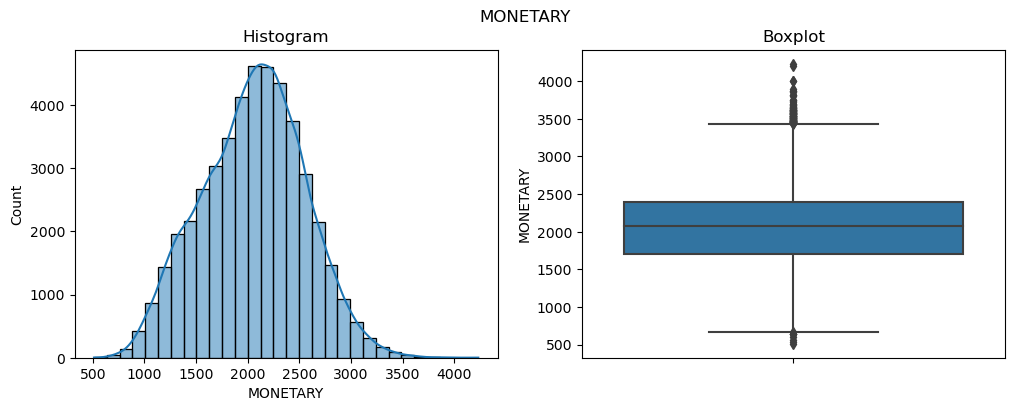

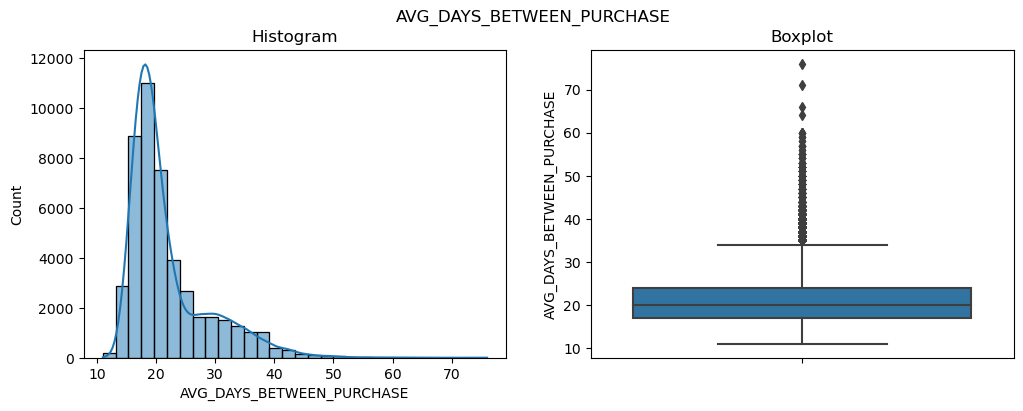

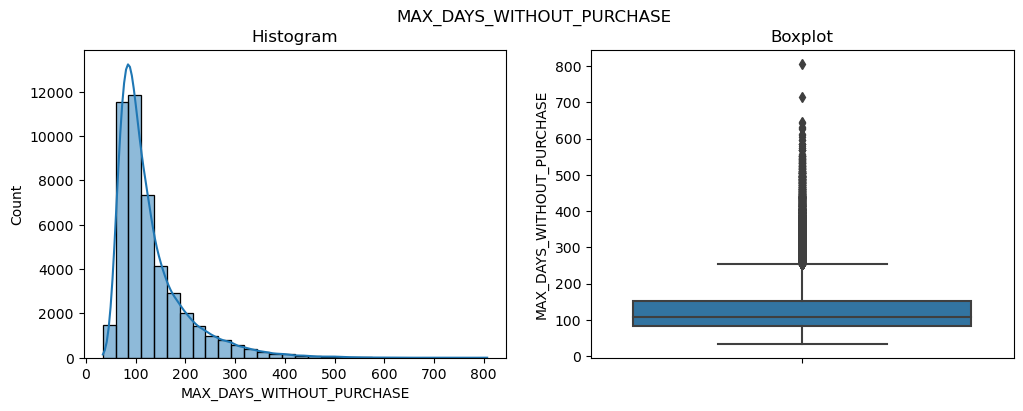

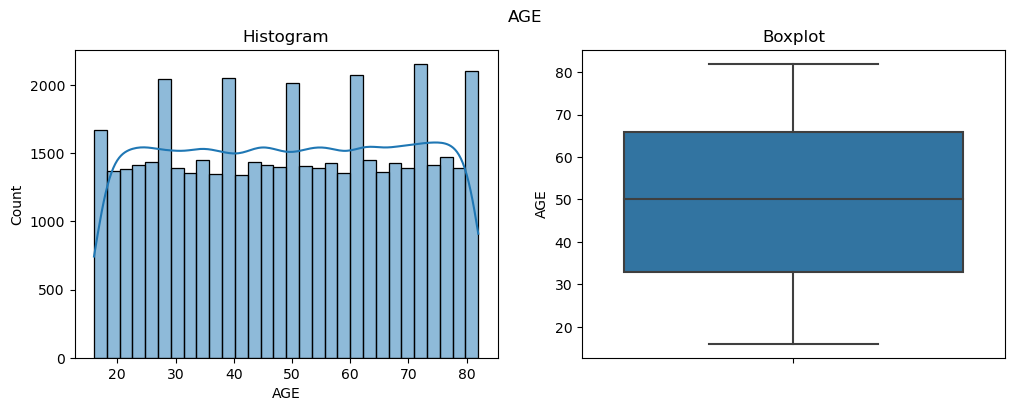

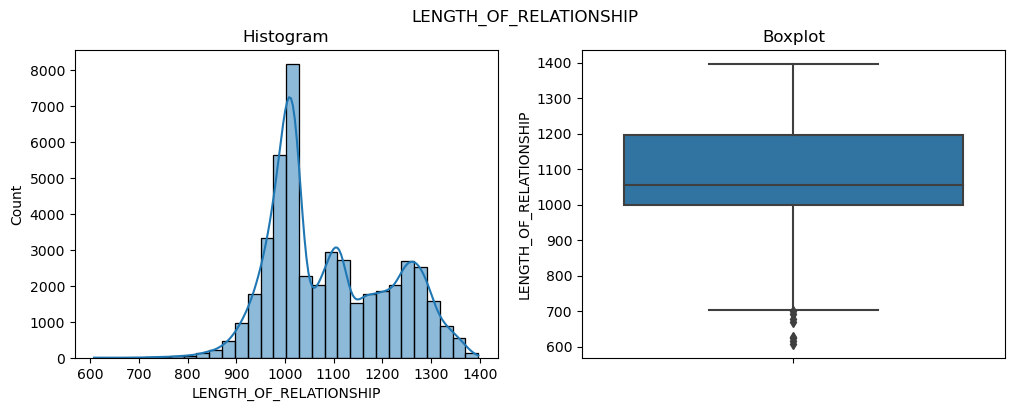

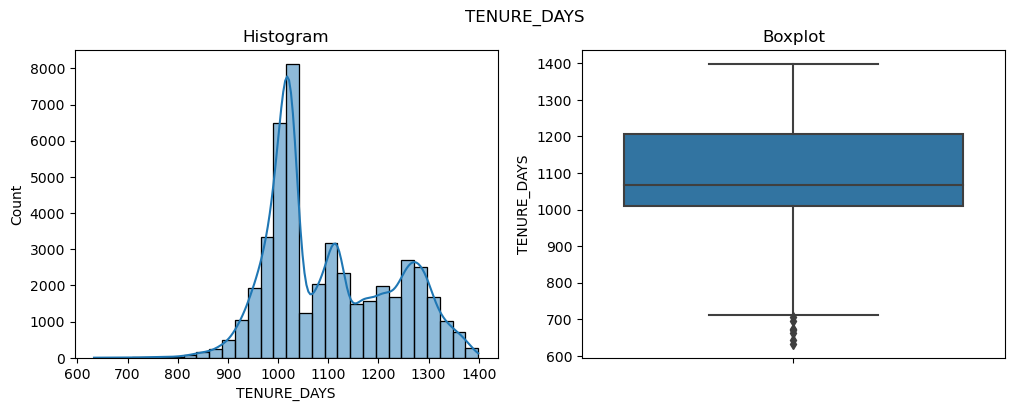

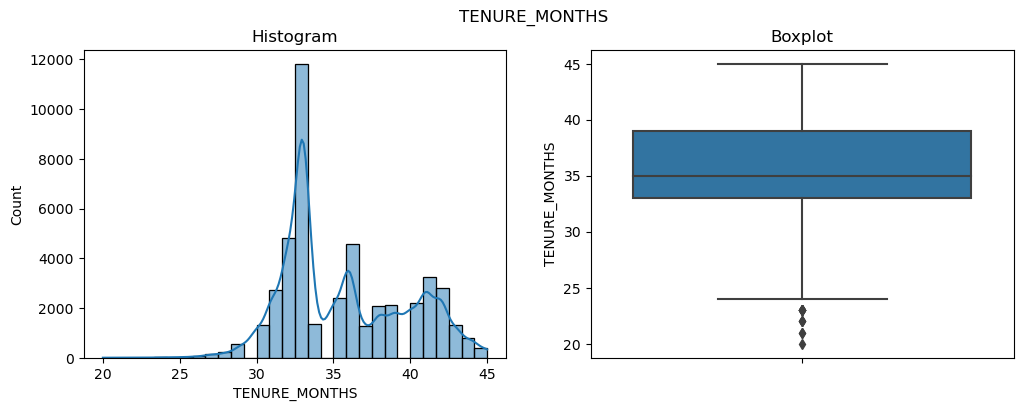

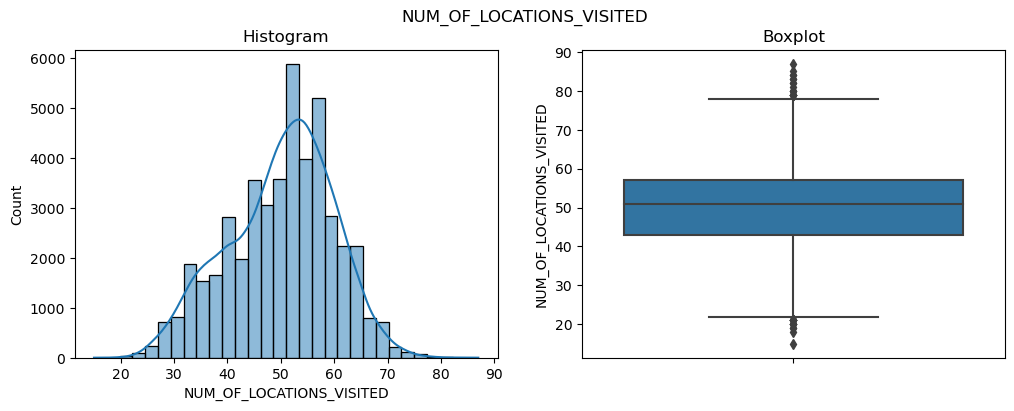

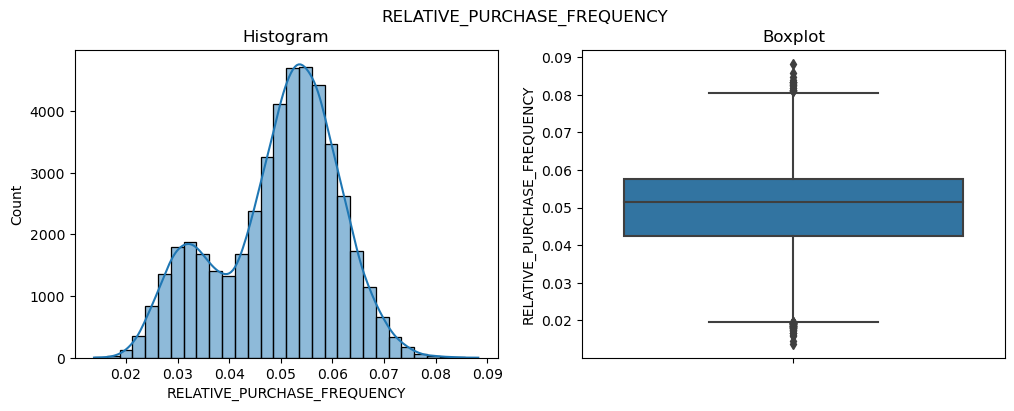

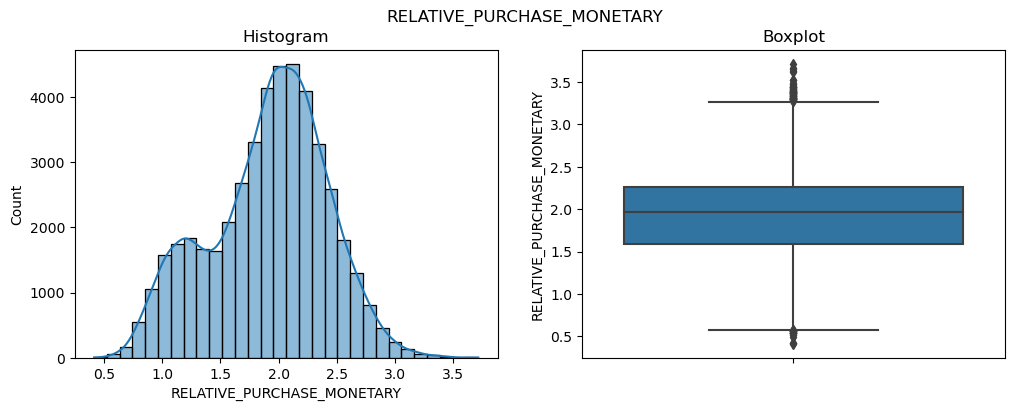

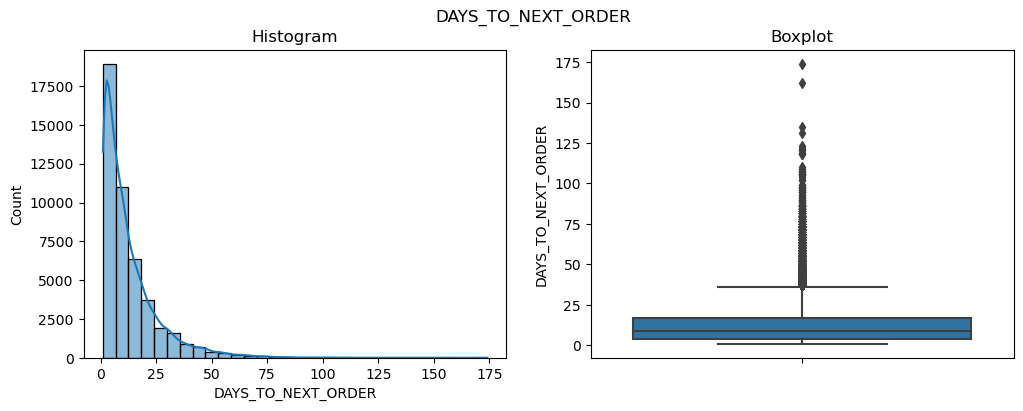

In [105]:
for i in num_cols.drop(['MIN_DAYS_WITHOUT_PURCHASE','CUSTOMER_ID']):
    diagnostic_plots(final_df,i)
    plt.show()

From the histograms, it can be seen that Recency, Average days between purchase, Maximum days without purchase and days to next order columns have a right skewed distribution. 

Frequency and Monetary have quite a normal distribution.

*Note there is no point dealing with outliers in Days to next order as even when dealt with, the 50% mark stays the same, meaning no change to our target variable.

### 3.2.3 Cap the Outliers

#### 3.2.3.1 Cap by IQR

In [106]:
# create the capper
windsorizer = Winsorizer(capping_method='iqr', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['RECENCY','AVG_DAYS_BETWEEN_PURCHASE','MAX_DAYS_WITHOUT_PURCHASE'])

windsorizer.fit(final_df)


Winsorizer(capping_method='iqr', tail='both',
           variables=['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE',
                      'MAX_DAYS_WITHOUT_PURCHASE'])

In [107]:
final_df_win = windsorizer.transform(final_df)

Cap by IQR for distributions with high skewness. (Outliers = 75th percentile onwards)

#### 3.2.3.2 Cap by Gaussian

In [108]:
# create the capper
windsorizer = Winsorizer(capping_method='gaussian', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['FREQUENCY'])

windsorizer.fit(final_df_win)

Winsorizer(tail='both', variables=['FREQUENCY'])

In [109]:
final_df_win = windsorizer.transform(final_df_win)

Cap by gaussian for distributions with a normal ditribution. (Outliers = 3 Standard-deviations away)

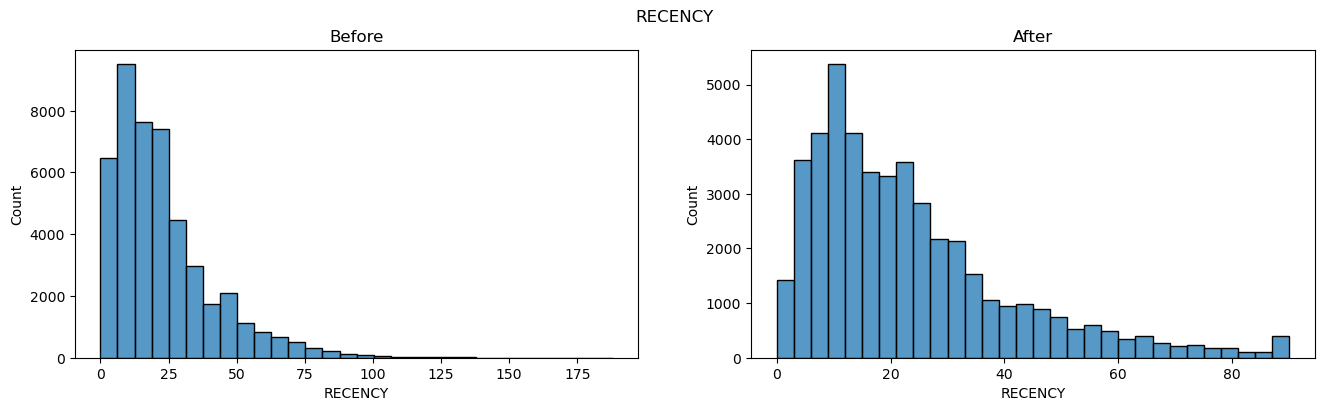

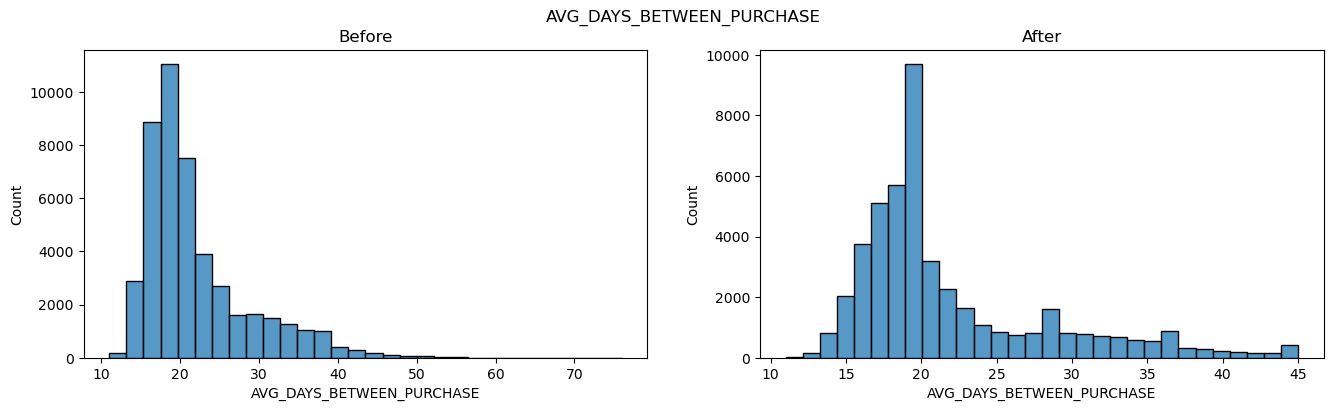

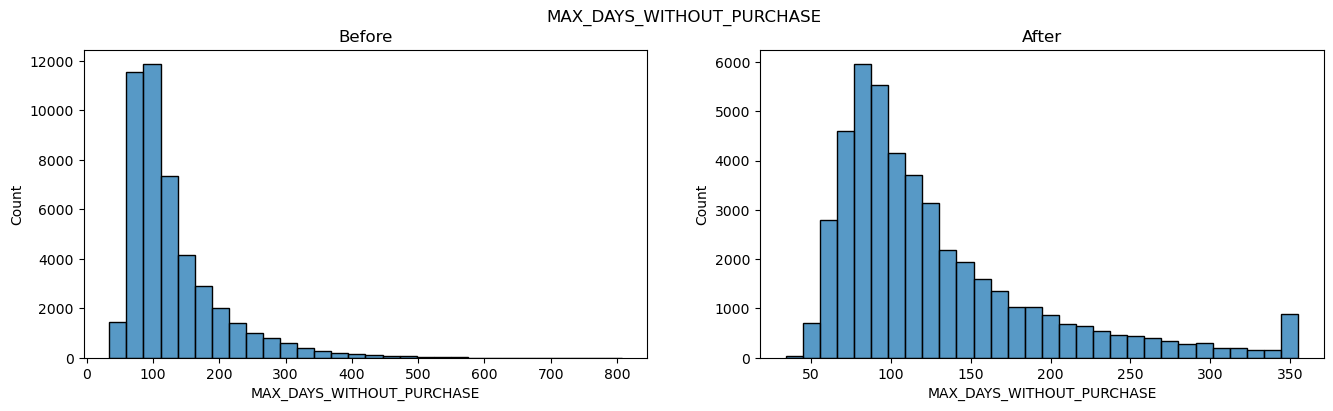

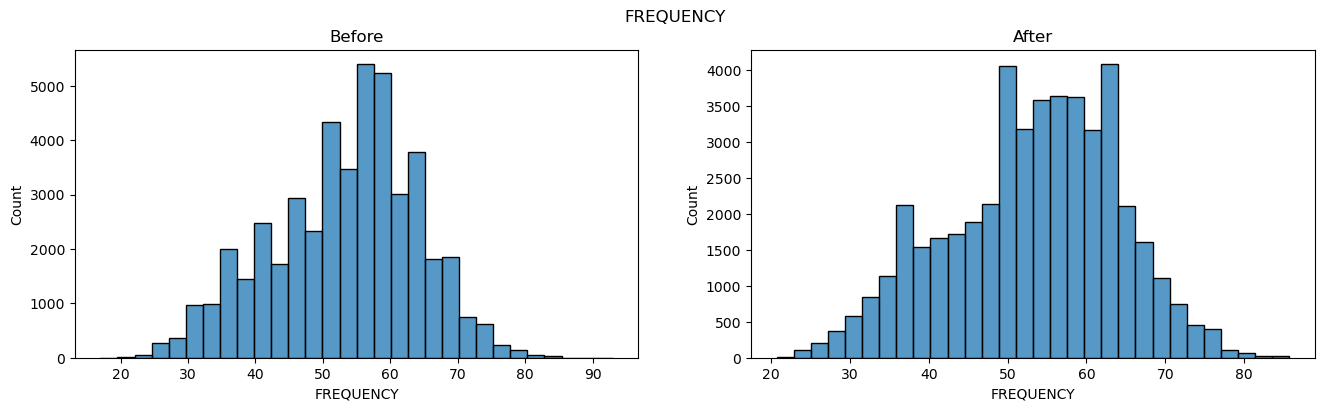

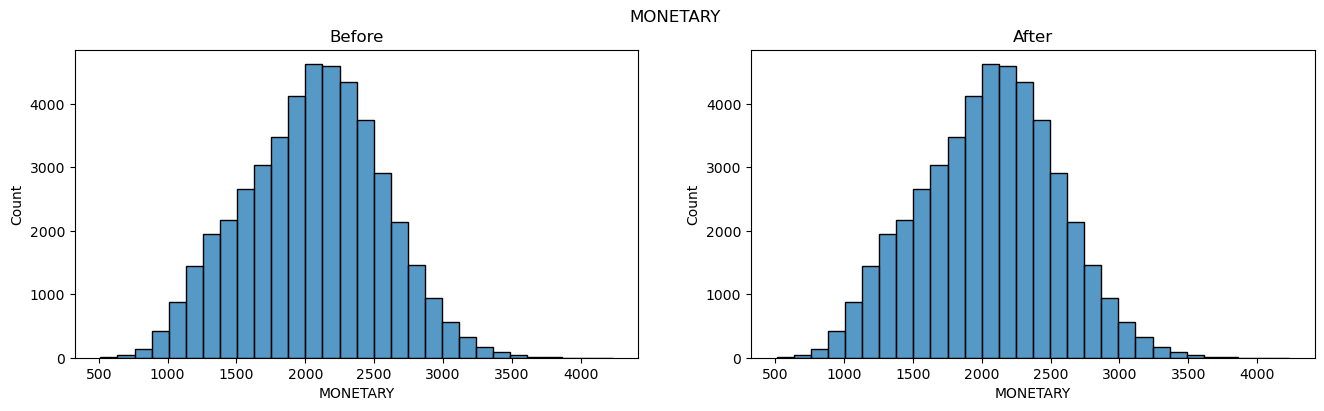

In [110]:
capped_cols = ['RECENCY','AVG_DAYS_BETWEEN_PURCHASE','MAX_DAYS_WITHOUT_PURCHASE','FREQUENCY','MONETARY']

for col in capped_cols:
        before_after_histogram(final_df,final_df_win,col)

It can be seen that much of the outliers have been 'Capped' where all values above a certain threshold are placed at the uppermost limit. This ensures that the machine learning model will not be trained for anomalies and outliers but for the majority of members

We see that AVG_DAYS_BETWEEN_PURCHASE and MAX_DAYS_WITHOUT_PURCHASE has had a significant amount of outlier handling done, where the maximum values for both have been halved, down from 70 to 45 and 800 to 350 respectively.

By reducing the variable range, it helps the model focus on the key patterns and relationships within the majority of the data.

## 3.3 Numerical Transformation

### 3.3.1 Visualise Numericals

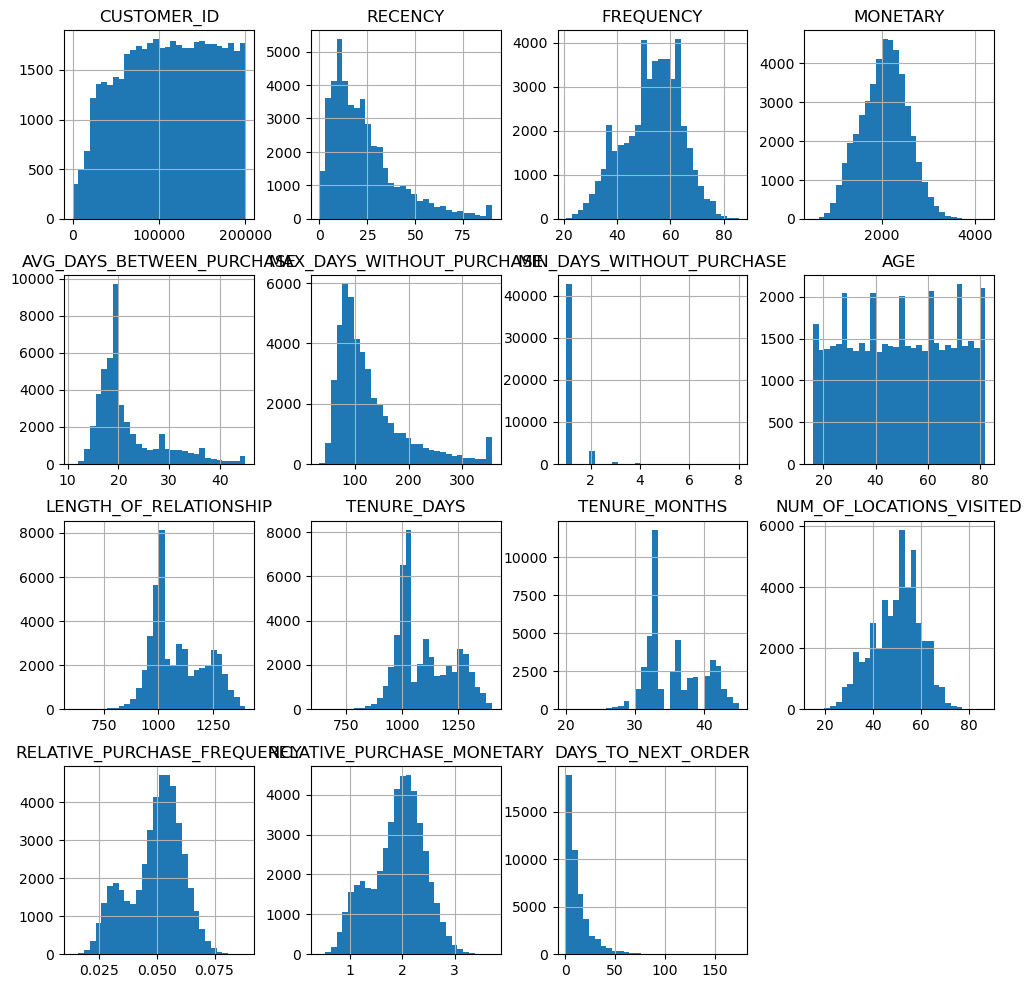

In [111]:
# plot the histogram to inspect variable distributions (not in book)

final_df_win.hist(bins=30, figsize=(12,12))
plt.show()

### 3.3.2 YeoJohnson Transformer

In [112]:
# create untransformed copy of the dataframe for customer segmentation
cust_seg_ori = final_df_win.copy()

# Add Target CHURNED
cust_seg_ori['CHURNED'] = 1
cust_seg_ori.loc[cust_seg_ori['DAYS_TO_NEXT_ORDER']<=14,'CHURNED'] = 0

In [113]:
# select variables to transform in a list
cols = ['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE', 'MAX_DAYS_WITHOUT_PURCHASE']

# initialize the transformer with a subset of variables to transform
yjt = YeoJohnsonTransformer(variables = cols)

# fit transformer to the dataframe
yjt.fit(final_df_win)

YeoJohnsonTransformer(variables=['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE',
                                 'MAX_DAYS_WITHOUT_PURCHASE'])

In [114]:
# transform indicated variables
final_df_yjt = yjt.transform(final_df_win)

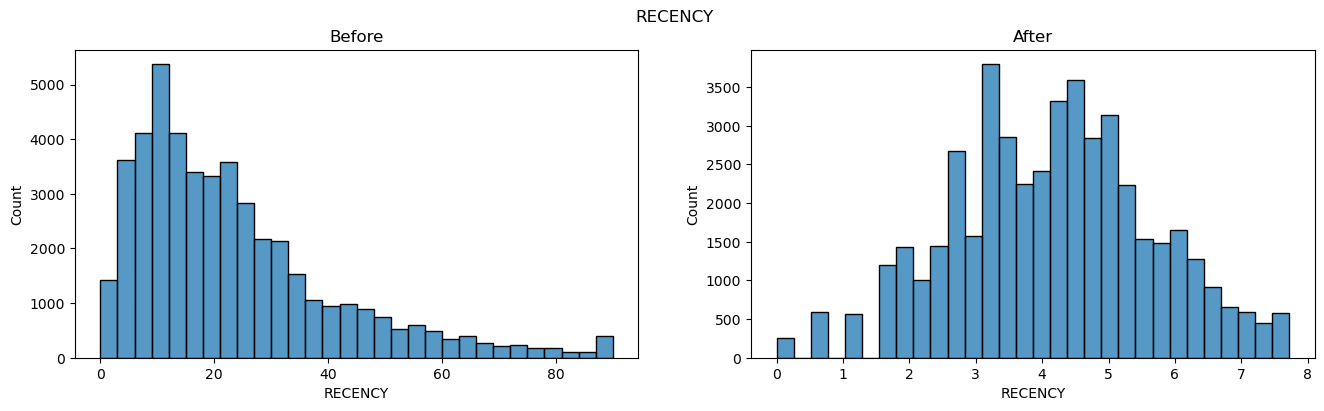

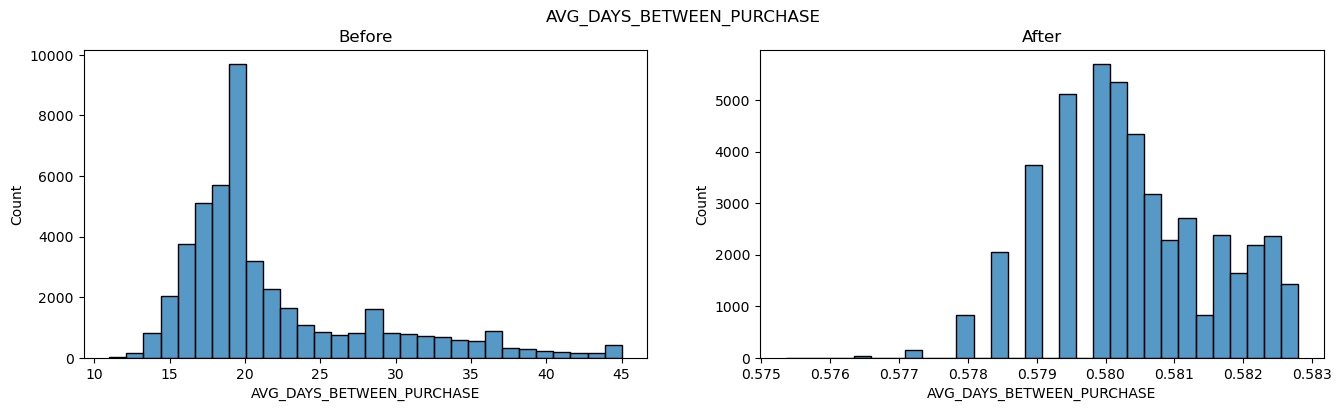

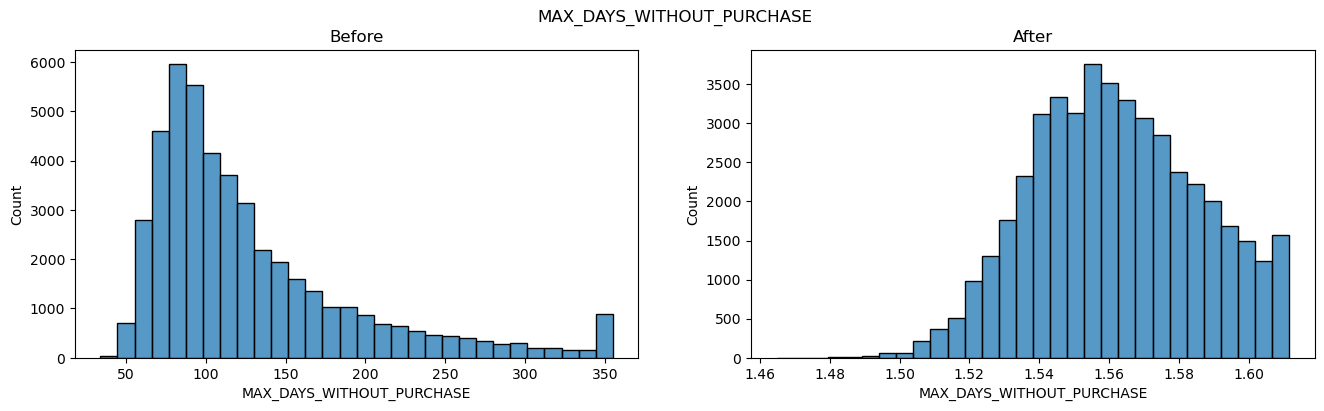

In [115]:
capped_cols = ['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE', 'MAX_DAYS_WITHOUT_PURCHASE']

for col in capped_cols:
        before_after_histogram(final_df_win,final_df_yjt,col)

It can be seen that the 3 variables to be transformed have achieved a more normal distribution. This ensures that the model avoids overfitting to the random noise of the data by reducing the variable range further, as well as further mitigates the effects of outliers.

# 4 Split the Data

In [122]:
# Train test split
X = final_df_yjt.drop(['CUSTOMER_ID','DAYS_TO_NEXT_ORDER','MAX_ORDER_TS','ORDER_TS','COUNTRY','BIRTHDAY_DATE','SIGN_UP_DATE','MONETARY','RELATIVE_PURCHASE_FREQUENCY',
       'RELATIVE_PURCHASE_MONETARY'], axis =1,
                  errors='ignore')
y = final_df_yjt["MONETARY"]


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.6,random_state=42)

In [124]:
# Test and holdout split
X_test,X_holdout,y_test,y_holdout=train_test_split(X_test,y_test,test_size=0.5,random_state=42)

## 4.1 Data Engineering 2

Data engineering needs to be done in 2 parts, one before and one after splitting the data so as to prevent data leakage to the test datasets

### 4.1.1 Categorical Encoding

#### 4.1.1.1 One Hot Encoding

In [125]:
# One Hot Encoding 
ohe_enc = OneHotEncoder(
     top_categories=None,
     drop_last=True,
     variables=['GENDER','MARITAL_STATUS','CITY','CHILDREN_COUNT']) 

ohe_enc.fit(X_train)
X_train = ohe_enc.transform(X_train)
X_test=ohe_enc.transform(X_test)
X_holdout=ohe_enc.transform(X_holdout)

#### 4.1.1.2 Clean the Encoded Columns

In [126]:
X_train.rename({'MARITAL_STATUS_Divorced/Seperated':'MARITAL_STATUS_Divorced_Or_Seperated'}, axis=1,inplace=True)
X_test.rename({'MARITAL_STATUS_Divorced/Seperated':'MARITAL_STATUS_Divorced_Or_Seperated'}, axis=1,inplace=True)
X_holdout.rename({'MARITAL_STATUS_Divorced/Seperated':'MARITAL_STATUS_Divorced_Or_Seperated'}, axis=1,inplace=True)

In [127]:
X_train.columns = map(str.upper, X_train.columns)
X_test.columns = map(str.upper, X_test.columns)
X_holdout.columns = map(str.upper, X_holdout.columns)

### 4.1.2 Feature Scaling

#### 4.1.2.1 Min Max Scaler

In [128]:
# Min Max Scaler

cols_to_scale=X_train.columns

scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train[cols_to_scale])

# transform train and test sets
X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test[cols_to_scale]= scaler.transform(X_test[cols_to_scale])
X_holdout[cols_to_scale]=scaler.transform(X_holdout[cols_to_scale])

# 5. Model Building

## 5.1 Define Evaluation Function

In [129]:
def evaluateRegressionModelPerformance(model, X_train, X_test, X_holdout, y_train, y_test, y_holdout):
    # Training evaluation
    print('Training Set:')
    train_pred=xgb_improved.predict(X_train)
    print('Mean Squared Error:', mean_squared_error(train_pred, y_train))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(train_pred, y_train)))
    print('R-squared:', r2_score(y_train, train_pred))
    print()

    # Testing evaluation
    print('Testing Set:')
    test_pred=xgb_improved.predict(X_test)
    print('Mean Squared Error:', mean_squared_error(test_pred, y_test))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(test_pred, y_test)))
    print('R-squared:', r2_score(y_test, test_pred))
    print()

    # Holdout evaluation
    print('Holdout Set:')
    holdout_pred=xgb_improved.predict(X_holdout)
    print('Mean Squared Error:', mean_squared_error(holdout_pred, y_holdout))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(holdout_pred, y_holdout)))
    print('R-squared:', r2_score(y_holdout, holdout_pred))

In [131]:
# Build XGBoost Model
xgb_improved = XGBRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 50)
# fit the model to the training data
xgb_improved.fit(X_train, y_train)

evaluateRegressionModelPerformance(xgb_improved, X_train, X_test, X_holdout, y_train, y_test, y_holdout)

Training Set:
Mean Squared Error: 41399.44325137809
Root Mean Squared Error: 203.46853135406
R-squared: 0.8320599200613849

Testing Set:
Mean Squared Error: 43373.11841372127
Root Mean Squared Error: 208.26213869477397
R-squared: 0.8235174626424333

Holdout Set:
Mean Squared Error: 44504.56051441065
Root Mean Squared Error: 210.9610402761862
R-squared: 0.8211712541688804


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

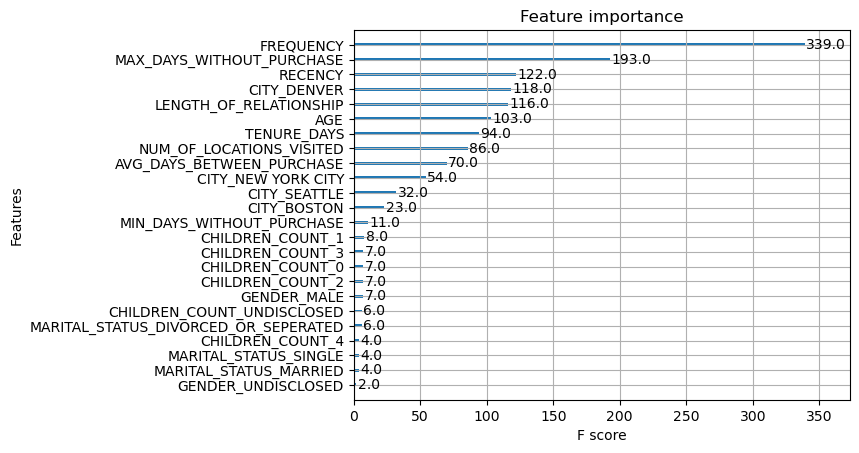

In [134]:
xgb.plot_importance(xgb_improved)